In [1]:
import imports as im
import functions as fn
%matplotlib inline

In [2]:
# Set path to directory with folders

path_train_audio = '../data/data/train_wav/' # kaggle data with .wav files
# path_train_audio = '../article_data/full_clips_all/' # article data

path_target_train = '../data/data/train.csv' # kaggle file with labels
# path_target_train = '../article_data/annotations_full.csv' # article file with labels

path_train_img = '../data/data/train_img/' # images directory path for kaggle data, where images will be stored
# path_train_img = '../article_data/data_images/' # images directory path for article data

Create spectrogram images

In [4]:
# it takes about 15-20 minutes
fn.create_images_data(path_train_audio, path_train_img, width=180, height=190)

Create datasets

- train : 90%
- val : 5%
- test : 5%

In [5]:
# Set path to directory with folders train and test
df = im.pd.read_csv(path_target_train)
# path_train_img_noised = '../datasets/pngs_from_wavs_noised_002/'

train_index = int(len(df["clip_name"]) * 0.9)
val_index = train_index + int(len(df["clip_name"]) * 0.05)

In [6]:
x_data, y_data = fn.CreateKaggleDataset(df, train_index, val_index, path_train_img=path_train_img, slice_name=5)

In [7]:
x_train_val, x_test, y_train_val, y_test = im.train_test_split(x_data, y_data, test_size=0.05, random_state=42, shuffle=True, stratify=y_data)

In [8]:
x_train, x_val, y_train, y_val = im.train_test_split(x_train_val, y_train_val, test_size=0.053, random_state=42, shuffle=True, stratify=y_train_val)

Let's show the example of spectrogram image

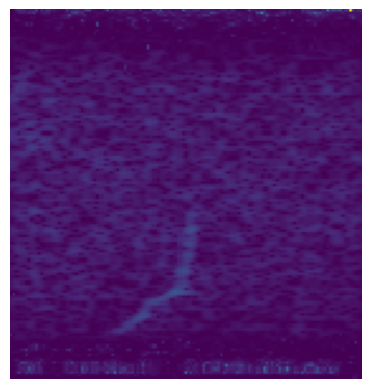

In [12]:
im.plt.axis("off")
im.plt.imshow(x_train[0])
im.plt.show()

In [13]:
batch_size = 64

train_data = im.tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(batch_size).prefetch(buffer_size=256)

val_data = im.tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).prefetch(buffer_size=256)

test_data = im.tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(buffer_size=256)

In [14]:
# Link for NN model Xception
im.ssl._create_default_https_context = im.ssl._create_unverified_context

### Xception Network

In [21]:
# https://keras.io/guides/transfer_learning/

Xception_model = im.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=x_train.shape[-3:],
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [22]:
# Freeze the base_model
Xception_model.trainable = False

In [23]:
inputs = im.keras.Input(shape=x_train.shape[-3:])
x = inputs
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = im.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

In [24]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = Xception_model(x, training=False)
x = im.keras.layers.GlobalAveragePooling2D()(x)
x = im.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = im.keras.layers.Dense(200)(x)
outputs = im.keras.layers.Dense(1)(x)
xception = im.keras.Model(inputs, outputs)

xception.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 146, 139, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 146, 139, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 200)               409800    
                                                           

In [27]:
weights_file_layers = '../weights_xception/xception_weights_layers.h5'
# xception.load_weights(weights_file_layers)

callback_layers = [
    im.ModelCheckpoint(
        weights_file_layers, mode='max', save_best_only=True
        ),
    im.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, mode='min', min_lr=0
    ),
]

xception.compile(
    optimizer=im.tf.keras.optimizers.legacy.Adam(),
    loss=im.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[im.keras.metrics.BinaryAccuracy()],
)

In [28]:
epochs = 20
HistoryTop = xception.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[callback_layers])

Epoch 1/20
422/422 [==============================] - 221s 522ms/step - loss: 0.3605 - binary_accuracy: 0.8197 - val_loss: 0.3662 - val_binary_accuracy: 0.8332 - lr: 0.0010
Epoch 2/20
422/422 [==============================] - 222s 527ms/step - loss: 0.3569 - binary_accuracy: 0.8217 - val_loss: 0.3677 - val_binary_accuracy: 0.8332 - lr: 0.0010
Epoch 3/20
422/422 [==============================] - 223s 529ms/step - loss: 0.3530 - binary_accuracy: 0.8238 - val_loss: 0.3699 - val_binary_accuracy: 0.8392 - lr: 0.0010
Epoch 4/20
422/422 [==============================] - 222s 526ms/step - loss: 0.3512 - binary_accuracy: 0.8250 - val_loss: 0.3651 - val_binary_accuracy: 0.8326 - lr: 0.0010
Epoch 5/20
422/422 [==============================] - 222s 526ms/step - loss: 0.3506 - binary_accuracy: 0.8245 - val_loss: 0.3702 - val_binary_accuracy: 0.8279 - lr: 0.0010
Epoch 6/20
422/422 [==============================] - 222s 527ms/step - loss: 0.3484 - binary_accuracy: 0.8259 - val_loss: 0.3684 - val

In [29]:
weights_file_finetun = '../weights_xception/xception_weights_finetun.h5'
callback_finetun = [
    im.ModelCheckpoint(
        weights_file_finetun, mode='max', save_best_only=True
        ),
    im.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.75, patience=3, mode='min', min_lr=0
    ),
]
# xception.load_weights(weights_file_finetun)

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
Xception_model.trainable = True

xception.summary()

xception.compile(
    optimizer=im.tf.keras.optimizers.legacy.Adam(1e-5),  # Low learning rate
    loss=im.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[im.keras.metrics.BinaryAccuracy()],
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 146, 139, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 146, 139, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 200)               409800    
                                                           

In [30]:
epochs = 10
HistoryFinetun = xception.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[callback_finetun])

Epoch 1/10
422/422 [==============================] - 883s 2s/step - loss: 0.2680 - binary_accuracy: 0.8749 - val_loss: 0.2193 - val_binary_accuracy: 0.9047 - lr: 1.0000e-05
Epoch 2/10
422/422 [==============================] - 879s 2s/step - loss: 0.1883 - binary_accuracy: 0.9130 - val_loss: 0.2037 - val_binary_accuracy: 0.9146 - lr: 1.0000e-05
Epoch 3/10
422/422 [==============================] - 882s 2s/step - loss: 0.1523 - binary_accuracy: 0.9299 - val_loss: 0.2001 - val_binary_accuracy: 0.9186 - lr: 1.0000e-05
Epoch 4/10
422/422 [==============================] - 886s 2s/step - loss: 0.1274 - binary_accuracy: 0.9424 - val_loss: 0.2074 - val_binary_accuracy: 0.9166 - lr: 1.0000e-05
Epoch 5/10
422/422 [==============================] - 886s 2s/step - loss: 0.1006 - binary_accuracy: 0.9550 - val_loss: 0.2161 - val_binary_accuracy: 0.9153 - lr: 1.0000e-05
Epoch 6/10
422/422 [==============================] - 884s 2s/step - loss: 0.0780 - binary_accuracy: 0.9662 - val_loss: 0.2361 - v

If we want to use model with trained weights

In [31]:
weights_file = '../weights_xception/xception_weights_finetun.h5'
xception.load_weights(weights_file)
xception.trainable = False

In [32]:
LossTop = HistoryTop.history['loss']
ValLossTop = HistoryTop.history['val_loss']

AccTop = HistoryTop.history['binary_accuracy']
ValAccTop = HistoryTop.history['val_binary_accuracy']

EpochsTop = range(1, len(LossTop) + 1)

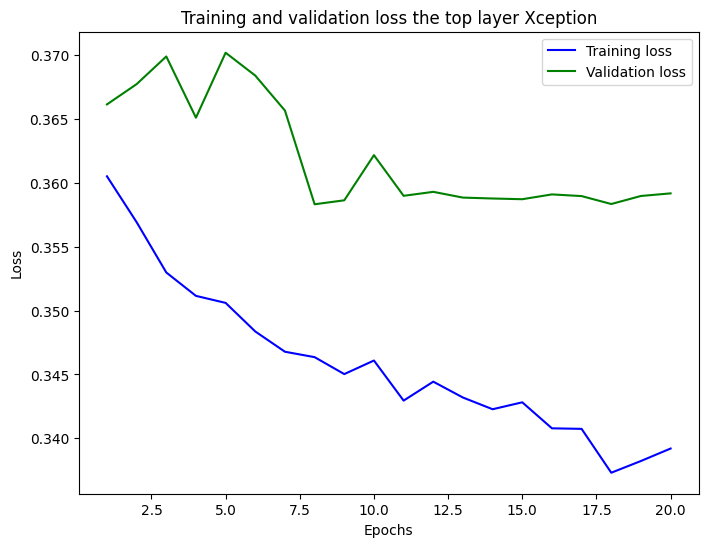

In [33]:
fn.PlotLossAcc(TrainData=LossTop, ValData=ValLossTop, Epochs=EpochsTop,
            TrainLabel='Training loss', ValLabel='Validation loss',
            yLabel='Loss', title='Training and validation loss the top layer Xception',
            ColTrain='blue', ColVal='green', filename="../images/loss_top.pdf")

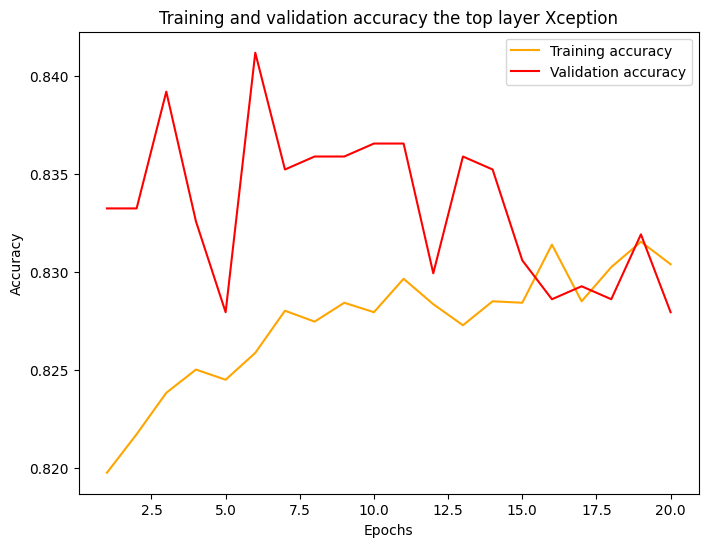

In [34]:
fn.PlotLossAcc(TrainData=AccTop, ValData=ValAccTop, Epochs=EpochsTop,
            TrainLabel='Training accuracy', ValLabel='Validation accuracy',
            yLabel='Accuracy', title='Training and validation accuracy the top layer Xception',
            ColTrain='orange', ColVal='red', filename="../images/accuracy_top.pdf")

In [35]:
LossFine = HistoryFinetun.history['loss']
ValLossFine = HistoryFinetun.history['val_loss']

AccFine = HistoryFinetun.history['binary_accuracy']
VallAccFine = HistoryFinetun.history['val_binary_accuracy']

EpochsFine = range(1, len(LossFine) + 1)

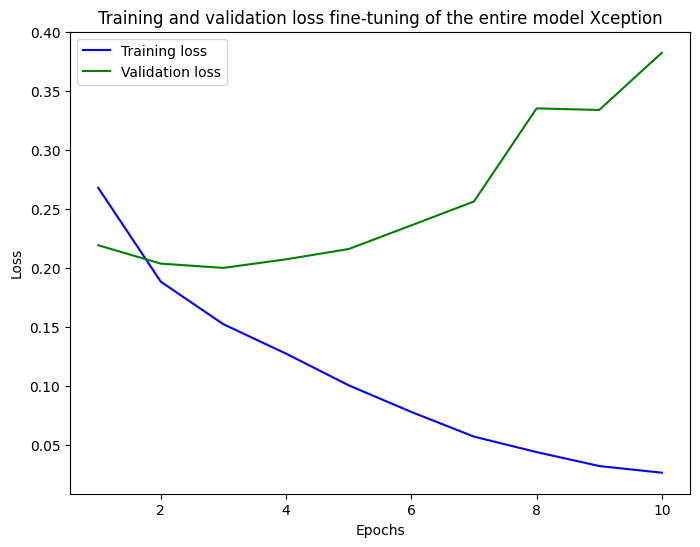

In [36]:
fn.PlotLossAcc(TrainData=LossFine, ValData=ValLossFine, Epochs=EpochsFine,
            TrainLabel='Training loss', ValLabel='Validation loss',
            yLabel='Loss', title='Training and validation loss fine-tuning of the entire model Xception',
            ColTrain='blue', ColVal='green', filename="../images/loss_fine.pdf")

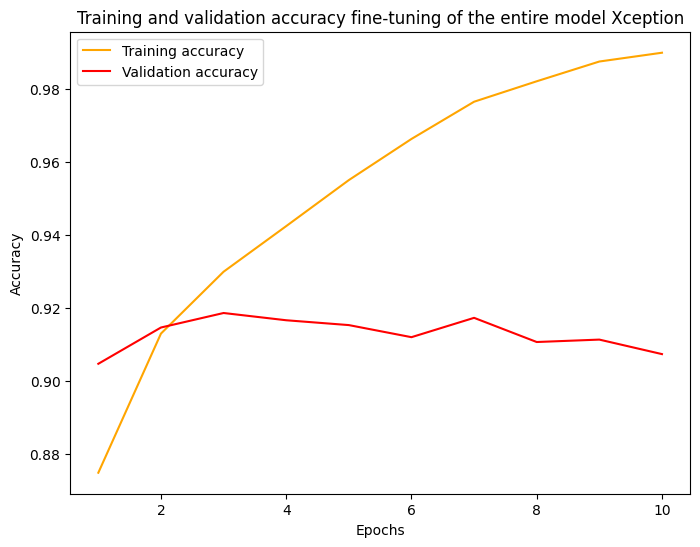

In [37]:
fn.PlotLossAcc(TrainData=AccFine, ValData=VallAccFine, Epochs=EpochsFine,
            TrainLabel='Training accuracy', ValLabel='Validation accuracy',
            yLabel='Accuracy', title='Training and validation accuracy fine-tuning of the entire model Xception',
            ColTrain='orange', ColVal='red', filename="../images/accuracy_fine.pdf")

Accuracy with trained weights is 97%. With noised data - 89.26%

In [38]:
score_x = xception.evaluate(test_data, verbose=0)
print("Xception test loss:", score_x[0])
print("Xception test accuracy:", score_x[1])

Xception test loss: 0.3891717791557312
Xception test accuracy: 0.9046666622161865
